# IMPORTING THE LIBRARIES

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [2]:
# Graph Adjustments
%matplotlib inline

In [3]:
# Current Directory
!dir

 Volume in drive C is OS
 Volume Serial Number is 4659-C57D

 Directory of C:\Users\amitk\Desktop

27-01-2023  02:12    <DIR>          .
27-01-2023  00:11    <DIR>          ..
27-01-2023  00:05    <DIR>          .ipynb_checkpoints
26-01-2023  19:56             1,038 04. Data Structures (Advanced) - Shortcut.lnk
24-01-2023  17:17            42,973 Amit Kumar Singh_Resume.docx
10-10-2022  18:05           108,175 Amit Kumar Singh_Resume.pdf
04-08-2022  22:53    <DIR>          Coding blocks
27-01-2023  01:25    <DIR>          csv_files
21-10-2022  01:03               830 DBMS - Shortcut.lnk
27-01-2023  02:12            19,255 Distracted Driver Detection .ipynb
27-01-2023  01:11    <DIR>          imgs
21-11-2022  20:25         1,727,620 Linux_terminal_command_Cheatsheet.pdf
26-01-2023  20:00               894 Live Classes - Shortcut.lnk
20-10-2022  01:14    <DIR>          Love Babbar Data Structures and Algorithms Notes
18-01-2023  21:52    <DIR>          Low level design
14-11-2021  15:49 

# Defining the train,test and model directories

We will create the directories for train,test and model training paths if not present

In [4]:
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [5]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

# Data Preparation

We will create a csv file having the location of the files present for training and test images and their associated class if present so that it is easily traceable.

In [6]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   22424 non-null  object
 1   ClassName  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [8]:
data_train['ClassName'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: ClassName, dtype: int64

In [9]:
data_train.describe()

,Filename,ClassName
count,22424,22424
unique,22424,10
top,C:\Users\amitk\Desktop\imgs\train\c0\img_10002...,c0
freq,1,2489


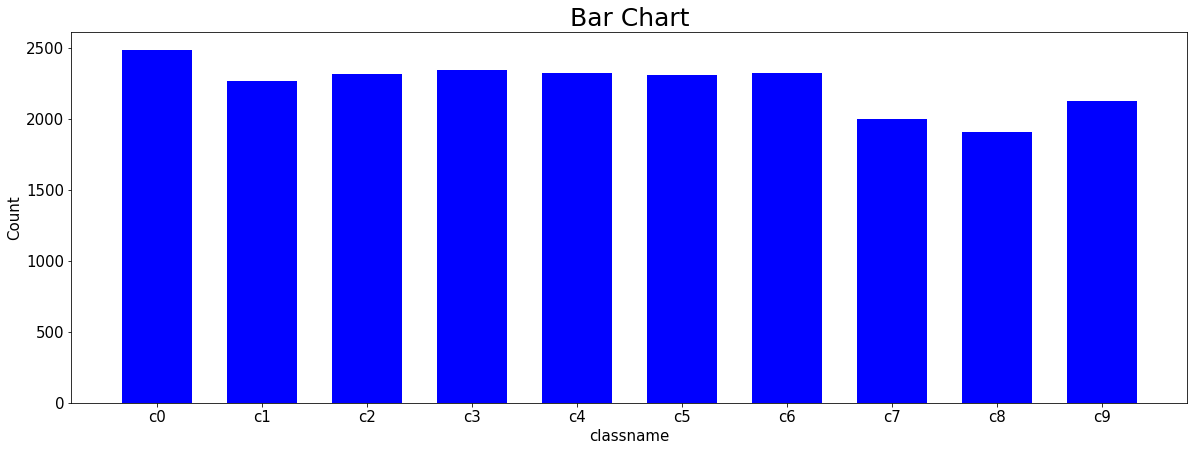

In [10]:


nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [11]:
data_test.head()

,FileName,ClassName
0,C:\Users\amitk\Desktop\imgs\test\img_1.jpg,test
1,C:\Users\amitk\Desktop\imgs\test\img_10.jpg,test
2,C:\Users\amitk\Desktop\imgs\test\img_100.jpg,test
3,C:\Users\amitk\Desktop\imgs\test\img_1000.jpg,test
4,C:\Users\amitk\Desktop\imgs\test\img_100000.jpg,test


In [12]:
data_test.shape

(79726, 2)

## Observation:
1. There are total 22424 training samples
2. There are total 79726 testing samples
3. The training dataset is equally balanced to a great extent and hence we need not do any downsampling of the data

## Converting into numerical values

In [13]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c7': 0, 'c6': 1, 'c0': 2, 'c4': 3, 'c3': 4, 'c2': 5, 'c1': 6, 'c5': 7, 'c8': 8, 'c9': 9}


In [14]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [15]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


## Splitting into Train and Test sets

In [16]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

### Converting into 64*64 images 

In [17]:

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [18]:

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5


100%|███████████████████████████████████████████████████████████████████████████| 17939/17939 [00:44<00:00, 402.54it/s]


In [19]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5


100%|█████████████████████████████████████████████████████████████████████████████| 4485/4485 [00:12<00:00, 349.20it/s]


In [20]:
##takes too much ram 
## run this if your ram is greater than 16gb 
# test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5 

# Defining the Model

In [21]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128,128,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 512)       5

In [22]:
plot_model(model,to_file=os.path.join(MODEL_PATH,"model_distracted_driver.png"),show_shapes=True,show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=25, batch_size=40, shuffle=True,callbacks=callbacks_list)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis

Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created 

In [ ]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig


In [ ]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)


In [ ]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = model.predict(valid_tensors)

In [ ]:
print_heatmap(ytest,ypred,class_names)

## Precision Recall F1 Score

In [ ]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [ ]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)